# Bin IMD, predict health from age

To fix poor correlation in full data

## Code setup

In [2]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [3]:
path_to_msoa_stats = os.path.join('data', 'msoa_collated.csv')

df_stats_old = pl.read_csv(path_to_msoa_stats)

In [4]:
df_stats_old.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761


Link MSOA names and codes:

In [5]:
path_to_msoa = os.path.join('data', 'Output_Area_to_LSOA_to_MSOA_to_Local_Authority_District_(December_2017)_Lookup_with_Area_Classifications_in_Great_Britain.csv')

df_msoa_names_codes = pl.read_csv(path_to_msoa)

In [6]:
df_msoa_names_codes = df_msoa_names_codes.unique(subset='MSOA11CD')[['MSOA11CD', 'MSOA11NM']]

In [7]:
df_msoa_names_codes

MSOA11CD,MSOA11NM
str,str
"""E02001329""","""Knowsley 003"""
"""E02001436""","""Sefton 008"""
"""S02001766""","""Dalgety Bay Central"""
"""S02002248""","""Blairgowrie East (Rattray)"""
"""E02005354""","""Charnwood 010"""
…,…
"""S02001519""","""Bishopbriggs North and Kenmure"""
"""S02001926""","""Roystonhill, Blochairn, and Pr…"
"""E02005608""","""South Norfolk 012"""


In [8]:
df_stats_old = df_stats_old.join(df_msoa_names_codes, left_on='MSOA', right_on='MSOA11NM', how='left')

df_stats_old.head(3)

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534"""
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535"""
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536"""


Newer stats dataframe with age band info:

In [9]:
path_to_msoa_stats = os.path.join('data', 'collated_data_regional_msoa11cd.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [10]:
df_stats.head()

msoa11cd,polygon_area_km2,population_density,income_domain_weighted_mean,imd_weighted_mean,weighted_ivt_time,mt_time_weighted_mean,ivt_time_weighted_mean,mt_transfer_time_weighted_mean,ethnic_group_other_than_white_british,ethnic_group_all_categories_ethnic_group,ethnic_minority_proportion,bad_or_very_bad_health,all_categories_general_health,bad_health_proportion,long_term_health_count,all_categories_long_term_health_problem_or_disability,long_term_health_proportion,age_65_plus_count,population_all,age_65_plus_proportion,age_band_all_0,age_0_proportion,age_band_all_5,age_5_proportion,age_band_all_10,age_10_proportion,age_band_all_15,age_15_proportion,age_band_all_20,age_20_proportion,age_band_all_25,age_25_proportion,age_band_all_30,age_30_proportion,age_band_all_35,age_35_proportion,age_band_all_40,age_40_proportion,age_band_all_45,age_45_proportion,age_band_all_50,age_50_proportion,age_band_all_55,age_55_proportion,age_band_all_60,age_60_proportion,age_band_all_65,age_65_proportion,age_band_all_70,age_70_proportion,age_band_all_75,age_75_proportion,age_band_all_80,age_80_proportion,age_band_all_85,age_85_proportion,age_band_all_90,age_90_proportion,rural_False,rural_True,proportion_rural,over_65_within_30_False,over_65_within_30_True,proportion_over_65_within_30,closest_is_mt_False,closest_is_mt_True,proportion_closest_is_mt
str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""E02000001""",7.4935,1459.6557,0.0693,15.4842,10.9293,10.7663,10.7663,0.0,3132,7375,0.4247,246,7375,0.0334,835,7187,0.1162,1731,10938,0.1583,474,0.0433,646,0.0591,465,0.0425,455,0.0416,1061,0.097,1445,0.1321,795,0.0727,680,0.0622,538,0.0492,663,0.0606,764,0.0698,672,0.0614,549,0.0502,508,0.0464,474,0.0433,300,0.0274,217,0.0198,116,0.0106,116,0.0106,10938.0,0.0,0.0,0.0,1731.0,1.0,0.0,10938.0,1.0
"""E02000002""",5.603,1378.9128,0.2165,34.8123,13.3056,13.2008,13.2008,0.0,2861,6775,0.4223,495,6775,0.0731,1346,6724,0.2002,979,7726,0.1267,674,0.0872,688,0.089,640,0.0828,527,0.0682,409,0.0529,528,0.0683,588,0.0761,551,0.0713,537,0.0695,494,0.0639,432,0.0559,404,0.0523,275,0.0356,231,0.0299,178,0.023,209,0.0271,166,0.0215,92,0.0119,103,0.0133,7726.0,0.0,0.0,0.0,979.0,1.0,0.0,7726.0,1.0
"""E02000003""",5.5425,2029.0451,0.1412,25.2469,10.2465,10.2794,10.2794,0.0,5291,10045,0.5267,521,10045,0.0519,1590,10033,0.1585,1284,11246,0.1142,956,0.085,860,0.0765,740,0.0658,644,0.0573,632,0.0562,865,0.0769,991,0.0881,950,0.0845,794,0.0706,726,0.0646,643,0.0572,604,0.0537,557,0.0495,349,0.031,336,0.0299,219,0.0195,183,0.0163,120,0.0107,77,0.0068,11246.0,0.0,0.0,0.0,1284.0,1.0,0.0,11246.0,1.0
"""E02000004""",6.4333,1033.0652,0.1402,23.8576,9.3787,9.3055,9.3055,0.0,1461,6182,0.2363,378,6182,0.0611,1016,5937,0.1711,1008,6646,0.1517,461,0.0694,476,0.0716,381,0.0573,385,0.0579,478,0.0719,555,0.0835,458,0.0689,427,0.0642,354,0.0533,419,0.063,422,0.0635,416,0.0626,406,0.0611,236,0.0355,238,0.0358,192,0.0289,142,0.0214,88,0.0132,112,0.0169,6646.0,0.0,0.0,0.0,1008.0,1.0,0.0,6646.0,1.0
"""E02000005""",3.0652,3438.5836,0.1571,29.6949,10.1,10.1,10.1,0.0,3534,8562,0.4128,528,8562,0.0617,1435,8562,0.1676,920,10540,0.0873,990,0.0939,923,0.0876,897,0.0851,720,0.0683,568,0.0539,728,0.0691,860,0.0816,887,0.0842,782,0.0742,692,0.0657,633,0.0601,547,0.0519,393,0.0373,268,0.0254,222,0.0211,169,0.016,124,0.0118,82,0.0078,55,0.0052,10540.0,0.0,0.0,0.0,920.0,1.0,0.0,10540.0,1.0


Only keep columns that match other MSOA dataframe:

In [11]:
cols_to_keep = [
    'msoa11cd',
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

In [12]:
df_stats = df_stats[cols_to_keep]

Merge together:

In [13]:
df_stats = df_stats_old.join(df_stats, left_on='MSOA11CD', right_on='msoa11cd', how='left')

In [14]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_0_proportion,age_5_proportion,age_10_proportion,age_15_proportion,age_20_proportion,age_25_proportion,age_30_proportion,age_35_proportion,age_40_proportion,age_45_proportion,age_50_proportion,age_55_proportion,age_60_proportion,age_65_proportion,age_70_proportion,age_75_proportion,age_80_proportion,age_85_proportion,age_90_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0515,0.0708,0.0614,0.0573,0.0449,0.0409,0.0508,0.0652,0.0682,0.0714,0.0745,0.0748,0.0555,0.0559,0.0528,0.0422,0.0322,0.0177,0.0121
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0518,0.074,0.0638,0.0454,0.03,0.0369,0.0386,0.0586,0.0678,0.0836,0.0691,0.0674,0.0597,0.0578,0.0774,0.0492,0.0369,0.0206,0.0117
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0461,0.0621,0.0697,0.0652,0.0404,0.0389,0.0501,0.0603,0.0643,0.0681,0.0753,0.0685,0.0639,0.0609,0.0582,0.0421,0.0385,0.0188,0.0088
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0616,0.0719,0.0608,0.0537,0.0463,0.0564,0.0611,0.0602,0.0696,0.072,0.0747,0.0679,0.0529,0.0465,0.0438,0.0367,0.0318,0.0213,0.0107
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0527,0.0618,0.0541,0.0367,0.0414,0.0517,0.0503,0.056,0.0666,0.081,0.0762,0.0742,0.0616,0.0597,0.067,0.0425,0.0313,0.0216,0.0133


Merge age bands under 65:

In [15]:
ages_to_merge = [
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    # 'age_65_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_less65_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

Merge age bands over 80:

In [16]:
ages_to_merge = [
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_over80_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

In [17]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Drop old proportion age bands to prevent confusion:

In [18]:
df_stats = df_stats.drop(['prop_0-64', 'prop_65-79', 'prop_80+', '0-64', '65-79', '80+'])

Check sum of admissions for Welsh areas:

In [19]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Welsh data is always zero so remove it.

In [20]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

In [21]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Find average admissions across all MSOA:

In [22]:
dict_average_admissions = {}
dict_average_admissions['mean'] = df_stats['admissions'].mean()
dict_average_admissions['median'] = df_stats['admissions'].median()
dict_average_admissions['mode'] = df_stats['admissions'].mode()

In [23]:
dict_average_admissions

{'mean': 11.92312223858483,
 'median': 11.3333333335,
 'mode': shape: (1,)
 Series: 'admissions' [f64]
 [
 	12.0
 ]}

Average value is around 11 or 12. Place this into the dataframe for easier use with existing fitting functions:

In [24]:
constant = -12

df_stats = df_stats.with_columns(pl.lit(constant).alias('constant'))

df_stats = df_stats.insert_column(-1, pl.Series('admissions_plus_constant', df_stats['admissions'] + constant))

## Bin IMD

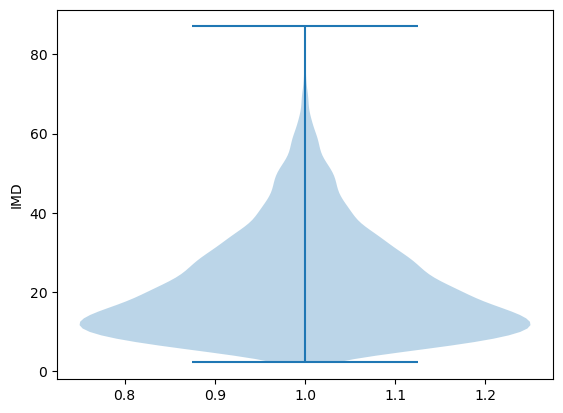

In [27]:
fig, ax = plt.subplots()
ax.violinplot(df_stats['IMD2019Score'])
ax.set_ylabel('IMD')
plt.show()

In [32]:
for q in [0.25, 0.50, 0.75]:
    print(f"{q:.2f}: {df_stats['IMD2019Score'].quantile(q):4.1f}")

0.25: 11.5
0.50: 18.3
0.75: 28.8


In [37]:
dict_quantiles = {}

for q in np.arange(0.0, 1.01, 0.1):
    v = df_stats['IMD2019Score'].quantile(q)
    print(f"{q:.2f}: {v:4.1f}")
    dict_quantiles[q] = v

0.00:  2.2
0.10:  7.7
0.20: 10.4
0.30: 12.7
0.40: 15.3
0.50: 18.3
0.60: 21.8
0.70: 26.4
0.80: 31.8
0.90: 40.7
1.00: 87.0


In [38]:
dict_quantiles

{0.0: 2.2122,
 0.1: 7.708,
 0.2: 10.369,
 0.30000000000000004: 12.74375,
 0.4: 15.2564,
 0.5: 18.3292857142857,
 0.6000000000000001: 21.81475,
 0.7000000000000001: 26.3611666666667,
 0.8: 31.84075,
 0.9: 40.6996,
 1.0: 87.02675}

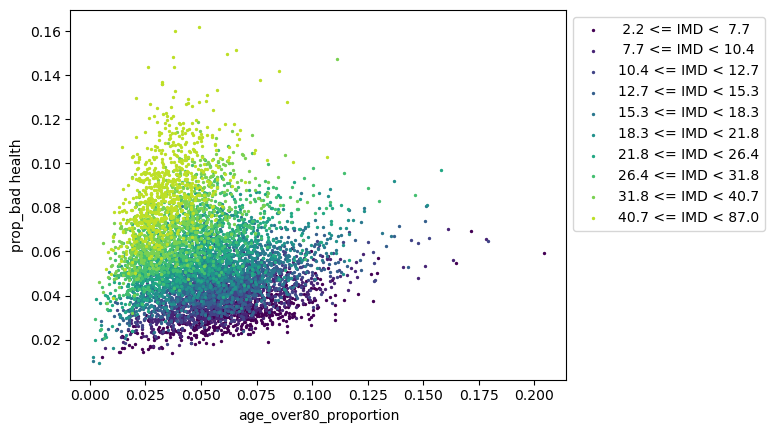

In [52]:
colour_list = plt.get_cmap('viridis')(np.linspace(0.0, 1.0, len(dict_quantiles)))

fig, ax = plt.subplots()

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    if q == len(dict_quantiles) - 1:
        q0 = dict_quantiles[quantile]
        mask = (df_stats['IMD2019Score'] >= q0)
        q_str = f'{q0:4.1f} < IMD'
    else:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
        q_str = f'{q0:4.1f} <= IMD < {q1:4.1f}'
    df_stats_here = df_stats.filter(mask)
    
    x = 'age_over80_proportion'
    y = 'prop_bad health'
    ax.scatter(df_stats_here[x], df_stats_here[y], label=q_str, s=2, color=colour_list[q])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    # ax.set_title(q_str)
    ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
plt.show()
    

0 0 0
1 1 0
2 0 1
3 1 1
4 0 2
5 1 2
6 0 3
7 1 3
8 0 4
9 1 4


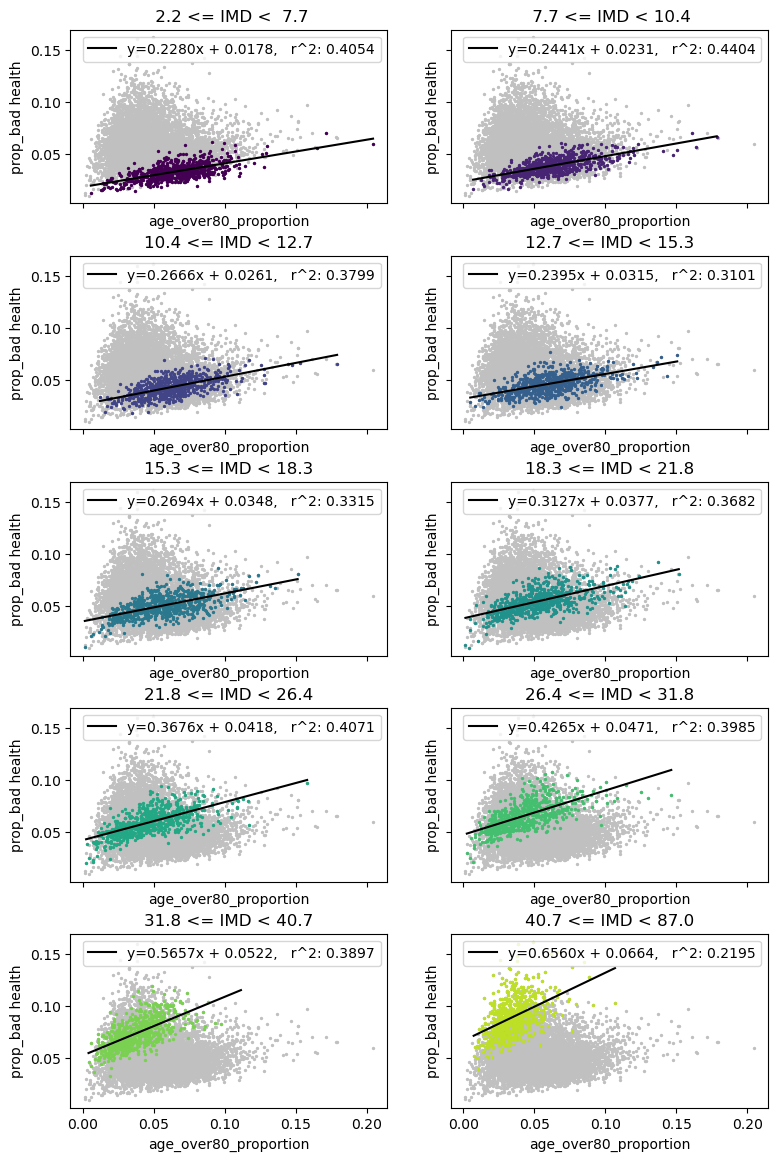

In [66]:
colour_list = plt.get_cmap('viridis')(np.linspace(0.0, 1.0, len(dict_quantiles)))

n_cols = 2
n_rows = 5
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(9, 14), gridspec_kw={'hspace': 0.3})

for q, quantile in enumerate(list(dict_quantiles.keys())[:-1]):
    if q == len(dict_quantiles) - 1:
        q0 = dict_quantiles[quantile]
        mask = (df_stats['IMD2019Score'] >= q0)
        q_str = f'{q0:4.1f} < IMD'
    else:
        q0 = dict_quantiles[quantile]
        q1 = dict_quantiles[list(dict_quantiles.keys())[q+1]]
        mask = (df_stats['IMD2019Score'] >= q0) & (df_stats['IMD2019Score'] < q1)
        q_str = f'{q0:4.1f} <= IMD < {q1:4.1f}'
    df_stats_here = df_stats.filter(mask)

    x_col = 'age_over80_proportion'
    y_col = 'prop_bad health'
    
    # Fit a line to this selection:
    y = (df_stats_here[y_col]).to_numpy()
    X = df_stats_here[x_col].to_numpy()
    # Add the constant:
    X = sm.add_constant(X)
    # Fit line:
    model = sm.OLS(y, X)
    results = model.fit()
    # Pick out coeffs, R^2:
    coeffs = results.params
    r2 = results.rsquared
    m = coeffs[1]
    c = coeffs[0]
    line_label = f'y={m:0.4f}x + {c:0.4f},   r^2: {r2:0.4f}'

    xmin = df_stats_here[x_col].min()
    xmax = df_stats_here[x_col].max()
    ymin = m*xmin + c
    ymax = m*xmax + c
    # ymin = df_stats_here[y_col].min()
    # ymax = df_stats_here[y_col].max()
    
    row = q % n_cols
    col = q // n_cols
    print(q, row, col)
    ax = axs[col, row]
    ax.scatter(df_stats[x_col], df_stats[y_col], s=2, color='silver')
    ax.scatter(df_stats_here[x_col], df_stats_here[y_col], s=2, color=colour_list[q])
    ax.plot([xmin, xmax], [ymin, ymax], color='k', label=line_label)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(q_str)
    ax.legend(loc='upper right')
    # ax.legend(bbox_to_anchor=[1.0, 1.0], loc='upper left')
plt.show()
    